In [1]:
%matplotlib inline

In [3]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import gzip
import re

In [2]:
def parse_line(l):
    if l[0] == '#': 
        return None
    if len(l) < 33:
        #print("ERROR: "+l)
        return None
    return {
        "task": re.sub("^ *", "", l[0:16]),
        "pid": int(re.sub(" +$", "", l[17:22])),
        "cpu": int(l[24:27]),
        "irq_off": l[29],
        "need_resched": l[30],
        "hardirq_softirq": l[31],
        "preempt_depth": int(l[32]),
        "timestamp": float(l[33:45]),
        "function": re.sub(":.*", "", l[48:])[:-1],
        "arguments": re.sub("[^:]+:", "", l[48:])[:-1]
    }

In [5]:
def load_log(tracefile):
    with gzip.open(tracefile) as f:
        return [
            line for line in [
            parse_line(line.decode()) 
            for line 
            in f
            ] if line != None
        ]

In [8]:
def query_state(trace):
    return [
        [line["timestamp"], 1 if re.match(".*(SQL_START|BDB_START|DELAY_end)", line["arguments"]) else 0, line["arguments"]]
        for line in trace
        if re.match(".*(DELAY_|SQL_|BDB_)", line["arguments"])
        and line["function"] == "tracing_mark_write"
        and line["task"] == "chmark_withjson"
    ]

In [7]:
test_log = load_log("../governor_traces/with_delaytags/0ms_conservative/YCSB_WorkloadA_TimingAsql.log.gz")

In [27]:
def compute_deltas(trace):
    state_changes = query_state(trace)
    state_on = state_changes[0::2]
    state_off = state_changes[1::2]
    assert( len([x for x in state_on if x[1] != 1]) == 0)
    assert( len([x for x in state_off if x[1] != 0]) == 0)
    start_time = state_on[0][0]
    state_pairs = zip([x[0] for x in state_on], [x[0] for x in state_off])
    return [
        (x[0]-start_time, x[1]-x[0])
        for x in state_pairs
    ]
compute_deltas(test_log)[0:3]

[(0.0, 0.010700000000014143),
 (0.010940000000005057, 0.008150000000000546),
 (0.019329999999996517, 0.0009100000000046293)]

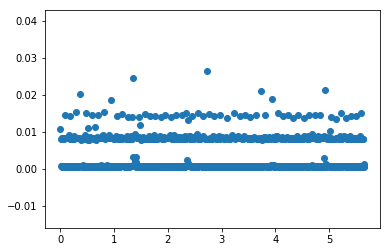

In [31]:
fig = plt.figure()
ax = fig.add_subplot(111)
deltas = compute_deltas(test_log)
ax.scatter(
    [x[0] for x in deltas],
    [x[1] for x in deltas],
)

In [34]:
all_governors = ["conservative", "interactive", "ondemand", "performance", "powersave", "userspace"]

In [35]:
A_log_traces = [ (gov, load_log(
    "../governor_traces/with_delaytags/log_"+gov+"/YCSB_WorkloadA_TimingAsql.log.gz"
    )
   )
   for gov in all_governors
]

In [44]:
A_log_deltas = [compute_deltas(x[1]) for x in A_log_traces]

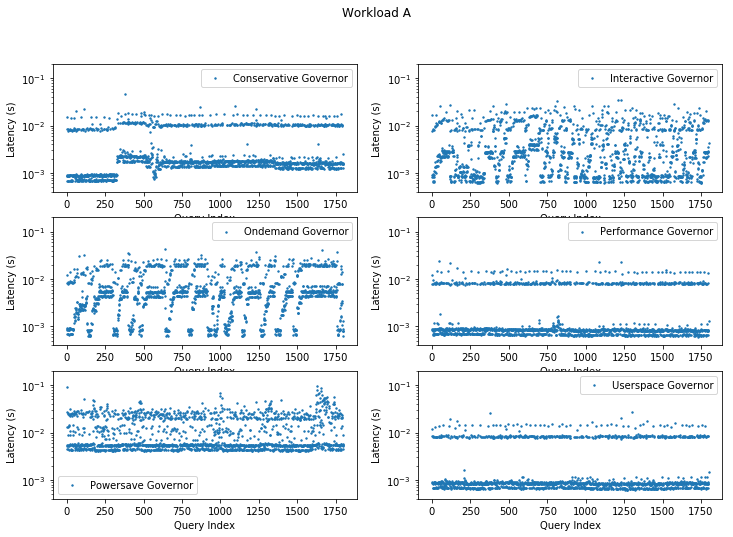

In [64]:
def plot_workload_deltas(deltas, workload_title):
    fig = plt.figure( figsize = (12, 8) )
    for i in range(0,6):
        ax = fig.add_subplot(321+i)
        ax.semilogy()
        ax.set_ylim(4e-4,2e-1)
        ax.set_xlabel("Query Index")
        ax.set_ylabel("Latency (s)")
        title = all_governors[i].title()+" Governor"
        ax.scatter(
            range(0, len(deltas[i])),
            [x[1] for x in deltas[i]],
            s=2, label = title
        )
        ax.legend()
    fig.suptitle(workload_title)
plot_workload_deltas(A_log_deltas, "Workload A")

In [62]:
B_log_traces = [ (gov, load_log(
    "../governor_traces/with_delaytags/log_"+gov+"/YCSB_WorkloadB_TimingAsql.log.gz"
    )
   )
   for gov in all_governors
]

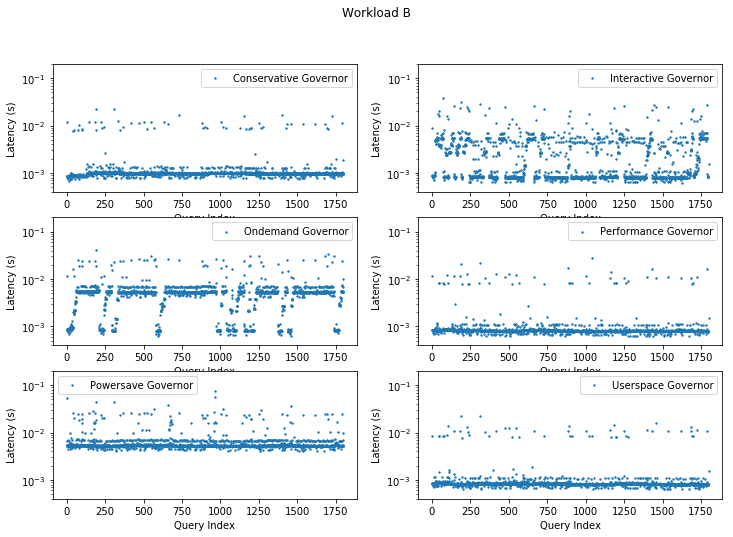

In [65]:
B_log_deltas = [compute_deltas(x[1]) for x in B_log_traces]
plot_workload_deltas(B_log_deltas, "Workload B")

In [67]:
C_log_traces = [ (gov, load_log(
    "../governor_traces/with_delaytags/log_"+gov+"/YCSB_WorkloadC_TimingAsql.log.gz"
    )
   )
   for gov in all_governors
]

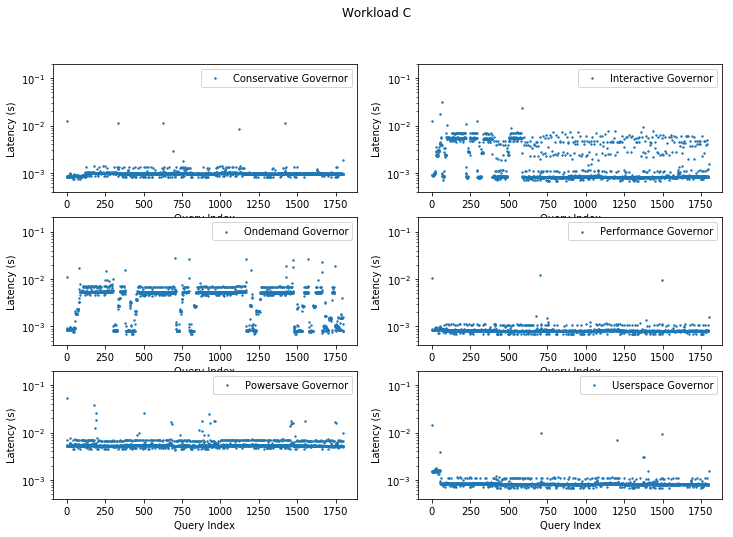

In [68]:
C_log_deltas = [compute_deltas(x[1]) for x in C_log_traces]
plot_workload_deltas(C_log_deltas, "Workload C")

In [69]:
D_log_traces = [ (gov, load_log(
    "../governor_traces/with_delaytags/log_"+gov+"/YCSB_WorkloadD_TimingAsql.log.gz"
    )
   )
   for gov in all_governors
]

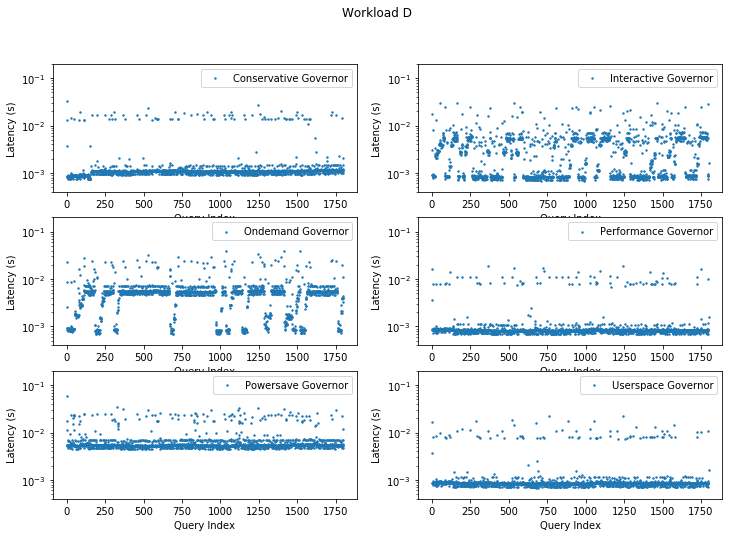

In [70]:
D_log_deltas = [compute_deltas(x[1]) for x in D_log_traces]
plot_workload_deltas(D_log_deltas, "Workload D")

In [71]:
E_log_traces = [ (gov, load_log(
    "../governor_traces/with_delaytags/log_"+gov+"/YCSB_WorkloadE_TimingAsql.log.gz"
    )
   )
   for gov in all_governors
]

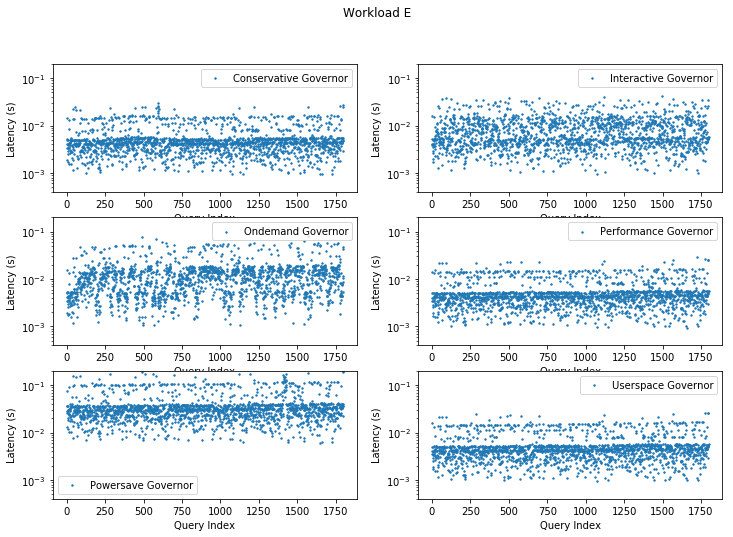

In [72]:
E_log_deltas = [compute_deltas(x[1]) for x in E_log_traces]
plot_workload_deltas(E_log_deltas, "Workload E")

In [73]:
F_log_traces = [ (gov, load_log(
    "../governor_traces/with_delaytags/log_"+gov+"/YCSB_WorkloadF_TimingAsql.log.gz"
    )
   )
   for gov in all_governors
]

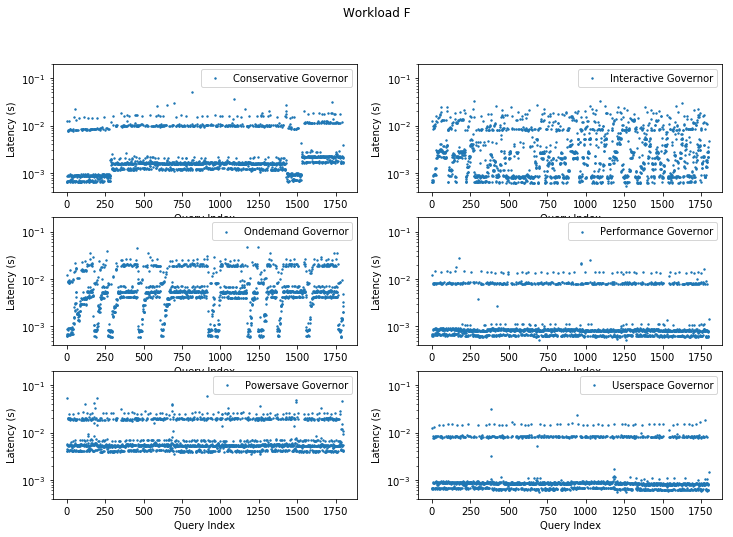

In [74]:
F_log_deltas = [compute_deltas(x[1]) for x in F_log_traces]
plot_workload_deltas(F_log_deltas, "Workload F")